In [2]:
import requests
import re
import os 

if os.path.exists('shakespeare.txt'):
    pass
else:
    # 下载并保存文件
    url = 'https://www.gutenberg.org/files/100/100-0.txt'
    response = requests.get(url)

    # 移除UTF-8 BOM
    text = response.content.decode('utf-8-sig') # 可以注释掉这行代码，你会发现获得的文本含有一些乱码

    with open('shakespeare.txt', 'w', encoding='utf-8') as file:
        file.write(text)

    print("下载完成并保存为 shakespeare.txt")

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer
from transformer import Transformer

# 1. 加载数据
with open('shakespeare.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# 2. 使用GPT2的分词器（或其他分词器）
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokens = tokenizer.encode(text)

# 3. 创建数据集
class ShakespeareDataset(Dataset):
    def __init__(self, tokens, seq_length):
        self.tokens = tokens
        self.seq_length = seq_length

    def __len__(self):
        return len(self.tokens) // self.seq_length

    def __getitem__(self, idx):
        start = idx * self.seq_length
        end = start + self.seq_length
        return torch.tensor(self.tokens[start:end], dtype=torch.long)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1686447 > 1024). Running this sequence through the model will result in indexing errors


In [6]:

# 4. 创建数据加载器
seq_length = 128
dataset = ShakespeareDataset(tokens, seq_length)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=8)

# 5. 定义模型、损失函数和优化器
model = Transformer(vocab_size=tokenizer.vocab_size, d_model=512, num_heads=8, num_layers=2, d_ff=2048, max_seq_len=seq_length)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [7]:
from tqdm import tqdm

# 6. 训练循环
for epoch in range(10):
    epoch_loss = 0  # 用于累积每个 epoch 的 loss
    with tqdm(dataloader, desc=f"Epoch {epoch+1}", unit="batch") as pbar:
        for batch in pbar:
            optimizer.zero_grad()
            output = model(batch[:, :-1], batch[:, 1:])
            loss = criterion(output.view(-1, tokenizer.vocab_size), batch[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()

            # 更新 epoch_loss
            epoch_loss += loss.item()

            # 实时显示当前 batch 的 loss
            pbar.set_postfix({"Batch Loss": loss.item()})

    # 计算并打印每个 epoch 的平均 loss
    avg_epoch_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/10], Avg Loss: {avg_epoch_loss:.4f}")

Epoch 1:  10%|▉         | 10/103 [01:34<14:43,  9.50s/batch, Batch Loss=8.45]


KeyboardInterrupt: 

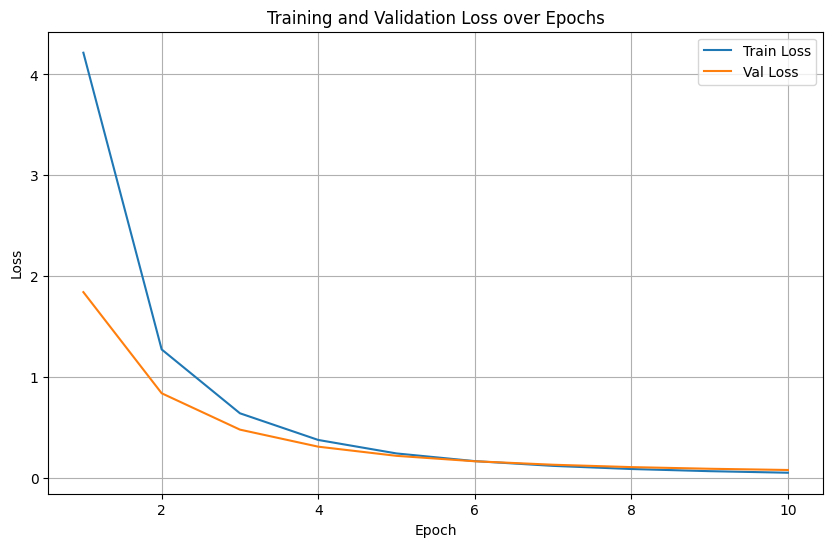

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
df = pd.read_csv('/teamspace/studios/this_studio/artifacts/loss_log.csv')

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(df['Epoch'], df['Train Loss'], label='Train Loss')
plt.plot(df['Epoch'], df['Val Loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()